In [119]:
%run necessary_functions.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
sns.set_style('darkgrid')

(5, 253)


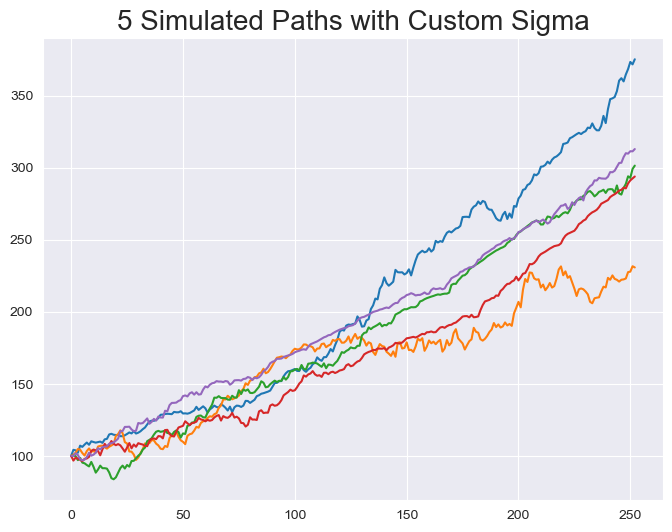

In [150]:

def stock_path_custom_sigma(S0, t, r, mu, phi, v0, rho, n_sims, n_steps):

    dt = t/n_steps
    # noise = np.random.normal(0,1,(n_paths, n_steps))
    # noise_v = np.random.normal(0,1,(n_paths, n_steps))
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + phi*(0.02 - vols[:, i]) * dt +
                                0.5*np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])

    return paths

S0 = 100
t = 1
r = 0.039
mu = 1
rho = -0.8
n_paths = 5
n_steps = 252
phi = 1
v0 = 0.1

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, v0, rho, n_paths, n_steps)

print(simulated_paths.shape)

plt.figure(figsize = (8,6))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)

plt.show()

In [157]:
#Simulate call payouts discounted to time 0
S0 = 100
t = 1
r = 0.039
mu = .1
rho = -0.8
n_sims = 1000
n_steps = 4 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.4**2
K = 110
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)

def objective(params, r):
    kappa, theta, xi, rho, v0 = params
    error = 0
    for stock_price in simulated_paths[:,-1]:
        model_price = heston_call(
        S0=100,
        K=110,
        v0=v0,
        r=0.039,
        t=1,
        kappa=kappa,
        theta=theta,
        xi=xi,
        rho=rho)
        
        error += (model_price - stock_price) ** 2

    return error

initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 
result = minimize(
    objective,
    initial_guess,
    args=(r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)
calibrated_params = result.x
kappa_opt, theta_opt, xi_opt, rho_opt, v0_opt = calibrated_params # array([1.0e+01, 1.0e+00, 1.0e-04, 9.9e-01, 1.0e+00])
hs_call = heston_call(S0 = 100, K = 110, v0 = v0_opt, r = 0.039, t = 1, 
                      kappa = kappa_opt, theta = theta_opt, xi = xi_opt, rho = rho_opt)

Simulated-Black Scholes Price: $25.31  with 1000 simulations 
and 4 control variants and standard error: 1.341592
------------------------------------------------------------------------------------------------------
Maximum profit: $416.02 
Minimum profit: $-355.43331987444725
------------------------------------------------------------------------------------------------------
Black Scholes Price of Call Option: $13.57


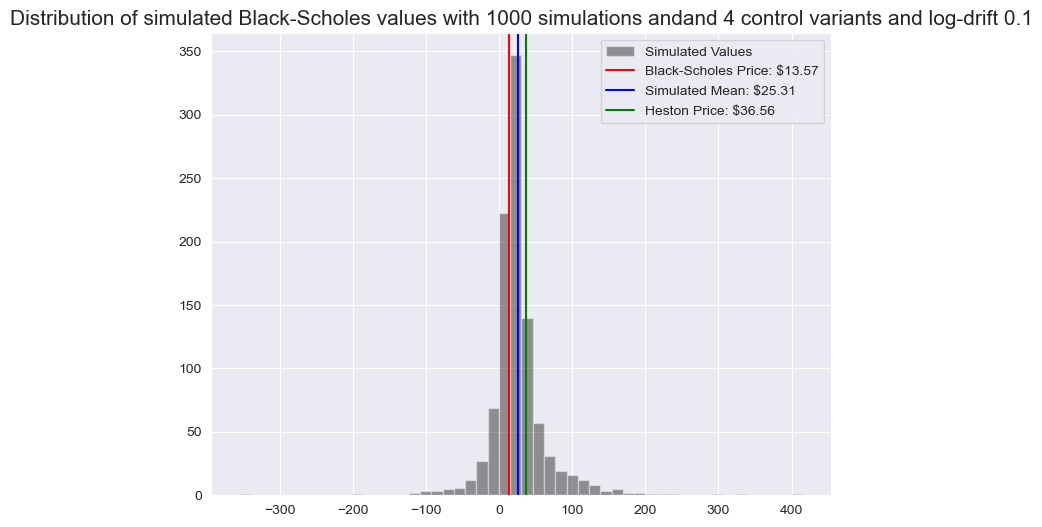

In [158]:
#Simulate call payouts discounted to time 0
S0 = 100
t = 1
r = 0.039
mu = .1
rho = -0.8
n_sims = 1000
n_steps = 4 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.4**2
K = 110
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)


sigma = np.sqrt(v0)
path_end_points = simulated_paths[:,-1]
call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)
dt = t/n_steps

delta_start = bs_call_delta(S0,K,sigma,t,r)
paths_first_steps = simulated_paths[:,0]
first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)
stock_profits = []
stock_profits.append(first_stock_profits)

## stock profits in intermediate steps
for i in range(1,n_hedges):
    stock_start = simulated_paths[:,i-1]
    stock_end = simulated_paths[:,i]
    tte = t-i*dt
    deltas = bs_call_delta(stock_start, K, sigma, tte, r)
    stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
    stock_profits.append(stock_profit)
    
total_stock_profit = np.sum(stock_profits, axis = 0)
profits_hedged = call_payouts - total_stock_profit
std_err = np.std(profits_hedged)/np.sqrt(n_sims)
bs_price = bs_call(S0,K,sigma,t,r)

#Comparison of simulated value with Black-Scholes
print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations \nand \
{n_hedges} control variants and standard error: {std_err:.6f}')
print('------'*17)
print(f'Maximum profit: ${np.max(profits_hedged):.2f} \nMinimum profit: ${np.min(profits_hedged)}')
print('------'*17)
print(f'Black Scholes Price of Call Option: ${bs_price:.2f}')

# Distribution of profits with delta hedging
plt.figure(figsize = (8,6))
plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
plt.axvline(hs_call, label = f'Heston Price: ${hs_call:.2f}', color = 'green')
plt.legend()
plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and\
and {n_hedges} control variants and log-drift {mu}',size = 15)
plt.show()

In [152]:
#Simulate call payouts discounted to time 0
S0 = 100
t = 1
r = 0.039
mu = .1
rho = -0.8
n_sims = 1000
n_steps = 12 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.4**2
K = 110
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)

def objective(params, r):
    kappa, theta, xi, rho, v0 = params
    error = 0
    for stock_price in simulated_paths[:,-1]:
        model_price = heston_call(
        S0=100,
        K=110,
        v0=v0,
        r=0.039,
        t=1,
        kappa=kappa,
        theta=theta,
        xi=xi,
        rho=rho)
        
        error += (model_price - stock_price) ** 2

    return error

initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 
result = minimize(
    objective,
    initial_guess,
    args=(r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)
calibrated_params = result.x
kappa_opt, theta_opt, xi_opt, rho_opt, v0_opt = calibrated_params # array([1.0e+01, 1.0e+00, 1.0e-04, 9.9e-01, 1.0e+00])
hs_call = heston_call(S0 = 100, K = 110, v0 = v0_opt, r = 0.039, t = 1, 
                      kappa = kappa_opt, theta = theta_opt, xi = xi_opt, rho = rho_opt)

Simulated-Black Scholes Price: $24.91  with 1000 simulations 
and 12 control variants and standard error: 0.910351
------------------------------------------------------------------------------------------------------
Maximum profit: $209.85 
Minimum profit: $-281.22193752817657
------------------------------------------------------------------------------------------------------
Black Scholes Price of Call Option: $13.57


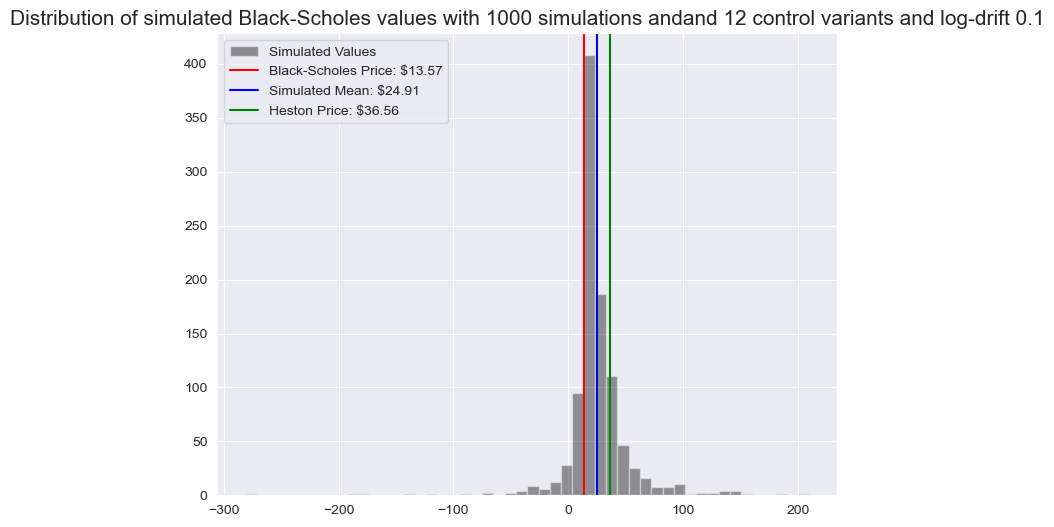

In [153]:
#Simulate call payouts discounted to time 0
S0 = 100
t = 1
r = 0.039
mu = .1
rho = -0.8
n_sims = 1000
n_steps = 12 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.4**2
K = 110
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)



sigma = np.sqrt(v0)
path_end_points = simulated_paths[:,-1]
call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)
dt = t/n_steps

delta_start = bs_call_delta(S0,K,sigma,t,r)
paths_first_steps = simulated_paths[:,0]
first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)
stock_profits = []
stock_profits.append(first_stock_profits)

## stock profits in intermediate steps
for i in range(1,n_hedges):
    stock_start = simulated_paths[:,i-1]
    stock_end = simulated_paths[:,i]
    tte = t-i*dt
    deltas = bs_call_delta(stock_start, K, sigma, tte, r)
    stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
    stock_profits.append(stock_profit)
    
total_stock_profit = np.sum(stock_profits, axis = 0)
profits_hedged = call_payouts - total_stock_profit
std_err = np.std(profits_hedged)/np.sqrt(n_sims)
bs_price = bs_call(S0,K,sigma,t,r)

#Comparison of simulated value with Black-Scholes
print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations \nand \
{n_hedges} control variants and standard error: {std_err:.6f}')
print('------'*17)
print(f'Maximum profit: ${np.max(profits_hedged):.2f} \nMinimum profit: ${np.min(profits_hedged)}')
print('------'*17)
print(f'Black Scholes Price of Call Option: ${bs_price:.2f}')

# Distribution of profits with delta hedging
plt.figure(figsize = (8,6))
plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
plt.axvline(hs_call, label = f'Heston Price: ${hs_call:.2f}', color = 'green')
plt.legend()
plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and\
and {n_hedges} control variants and log-drift {mu}',size = 15)
plt.show()

In [154]:
#Simulate call payouts discounted to time 0
S0 = 100
t = 1
r = 0.039
mu = .1
rho = -0.8
n_sims = 1000
n_steps = 252 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.4**2
K = 110
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)

def objective(params, r):
    kappa, theta, xi, rho, v0 = params
    error = 0
    for stock_price in simulated_paths[:,-1]:
        model_price = heston_call(
        S0=100,
        K=110,
        v0=v0,
        r=0.039,
        t=1,
        kappa=kappa,
        theta=theta,
        xi=xi,
        rho=rho)
        
        error += (model_price - stock_price) ** 2

    return error

initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 
result = minimize(
    objective,
    initial_guess,
    args=(r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)
calibrated_params = result.x
kappa_opt, theta_opt, xi_opt, rho_opt, v0_opt = calibrated_params # array([1.0e+01, 1.0e+00, 1.0e-04, 9.9e-01, 1.0e+00])
hs_call = heston_call(S0 = 100, K = 110, v0 = v0_opt, r = 0.039, t = 1, 
                      kappa = kappa_opt, theta = theta_opt, xi = xi_opt, rho = rho_opt)

Simulated-Black Scholes Price: $25.95  with 1000 simulations 
and 252 control variants and standard error: 0.518716
------------------------------------------------------------------------------------------------------
Maximum profit: $78.73 
Minimum profit: $-397.5444975678515
------------------------------------------------------------------------------------------------------
Black Scholes Price of Call Option: $13.57


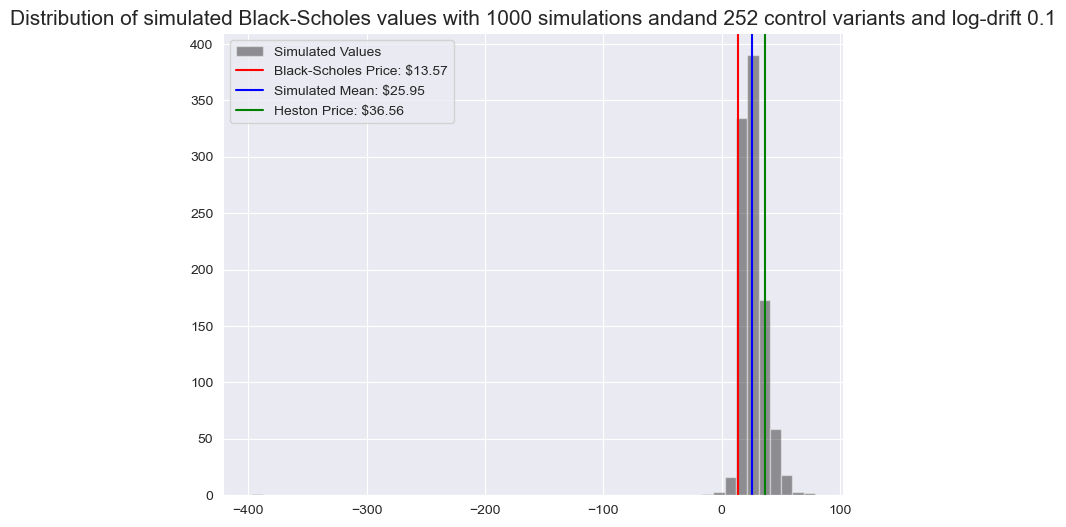

In [156]:
#Simulate call payouts discounted to time 0
S0 = 100
t = 1
r = 0.039
mu = .1
rho = -0.8
n_sims = 1000
n_steps = 252 # number of contorl variates
n_hedges = n_steps
phi = 1
v0 = 0.4**2
K = 110
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, rho, v0, n_sims, n_steps)

sigma = np.sqrt(v0)
path_end_points = simulated_paths[:,-1]
call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)
dt = t/n_steps

delta_start = bs_call_delta(S0,K,sigma,t,r)
paths_first_steps = simulated_paths[:,0]
first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)
stock_profits = []
stock_profits.append(first_stock_profits)

## stock profits in intermediate steps
for i in range(1,n_hedges):
    stock_start = simulated_paths[:,i-1]
    stock_end = simulated_paths[:,i]
    tte = t-i*dt
    deltas = bs_call_delta(stock_start, K, sigma, tte, r)
    stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
    stock_profits.append(stock_profit)
    
total_stock_profit = np.sum(stock_profits, axis = 0)
profits_hedged = call_payouts - total_stock_profit
std_err = np.std(profits_hedged)/np.sqrt(n_sims)
bs_price = bs_call(S0,K,sigma,t,r)

#Comparison of simulated value with Black-Scholes
print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations \nand \
{n_hedges} control variants and standard error: {std_err:.6f}')
print('------'*17)
print(f'Maximum profit: ${np.max(profits_hedged):.2f} \nMinimum profit: ${np.min(profits_hedged)}')
print('------'*17)
print(f'Black Scholes Price of Call Option: ${bs_price:.2f}')

# Distribution of profits with delta hedging
plt.figure(figsize = (8,6))
plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
plt.axvline(hs_call, label = f'Heston Price: ${hs_call:.2f}', color = 'green')
plt.legend()
plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and\
and {n_hedges} control variants and log-drift {mu}',size = 15)
plt.show()